In [1]:
import numpy as np
np.random.seed(4761)

cs = [('A', 11), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), ('7', 7), ('8', 8), ('9', 9), ('10', 10), ('J', 10), ('Q', 10), ('K', 10)]


class Card:
    def __init__(self, sym, value):
        self.sym = sym
        self.value = value
        
deck = [Card(x[0], x[1]) for x in cs]
BUST = 21
ADJ_ACE = deck[0].value - 1

class Hand:
    def __init__(self):
        self.sum = 0
        self.hasAce = False
        self.bust = False
        self.blackjack = False
        self.rawCards = []
        self.cards = []
        
    def __str__(self):
        return ' '.join([str((x.sym, x.value)) for x in self.cards])
        
    def computeSum(self):
        self.sum = 0  # this is inefficient
        for c in self.cards:  # assume A comes at the end
            self.sum += c.value
            if 'A' == c.sym:
                if self.sum > BUST:
                    self.sum -= ADJ_ACE  # 11 -> 1

    def addCard(self, card):
        if card.sym == 'A':
            self.hasAce = True
        self.rawCards.append(card)
        self.cards.append(card)
        self.cards.sort(key=lambda x: x.value)
        self.computeSum()
        self.checkBust()
        
    def checkBlackjack(self):
        if self.sum == 21:
            self.blackjack = True
        
    def checkBust(self):
        if self.sum > BUST:
            self.bust = True
            
    @staticmethod
    def getCard(sym):
        for c in deck:
            if c.sym == sym:
                return c
          
    def hit(self, sym=None):
        if sym:
            return self.getCard(sym)
        else:
            return deck[np.random.randint(len(deck))]


In [2]:
class Dealer(Hand):
    def __init__(self, show=None, down=None):
        Hand.__init__(self)
        self.stay = False
        self.show = self.getCard(show) if show else self.hit()
        self.addCard(self.show)
        self.down = self.getCard(down) if down else self.hit()
        self.addCard(self.down)
        self.checkBlackjack()

    def play(self, sym=None):
        if self.sum < 17:
            self.addCard(self.hit(sym))
        elif self.sum == 17:
            if self.hasAce:
                self.addCard(self.hit(sym))
            else:
                self.stay = True
        else:
            self.stay = True
            

In [3]:
dealer = Dealer()
assert 11 >= dealer.show.value >= 2 and 11 >= dealer.down.value >= 2
dealer = Dealer(show='3')
assert dealer.show.value == 3
assert sorted([x.value for x in dealer.cards]) == [x.value for x in dealer.cards]

In [4]:
dealer = Dealer(show='A', down='K')
assert dealer.blackjack
assert not dealer.bust
assert dealer.hasAce
assert dealer.sum == 21
dealer.play()
assert dealer.stay

In [5]:
dealer = Dealer(show='3', down='9')
dealer.play('A')
assert dealer.sum == 13 
assert not dealer.bust
dealer.play('6')
dealer.play('A')  # doesn't run because we have over 17
print(dealer)
assert dealer.sum == 19

('3', 3) ('6', 6) ('9', 9) ('A', 11)


In [6]:
dealer = Dealer(show='3', down='9')
dealer.play('K')
assert dealer.sum == 22
assert dealer.bust

## run simulation

### showing a 3

In [7]:
import pandas as pd

show = 3

res = []
n = 1000000

for _ in range(n):
    dealer = Dealer(show=show)
    while not dealer.stay:
        dealer.play()
    res.append([dealer.sum, dealer.bust, dealer.blackjack, ', '.join([x.sym for x in dealer.cards]), ', '.join([x.sym for x in dealer.rawCards])])
    del dealer
df = pd.DataFrame(res, columns=['Sum', 'Bust', 'Blackjack', 'Cards', 'Original Cards'])

In [8]:
df.Bust.sum() / len(df)

0.391385

In [16]:
df['Sum2'] = df['Sum'].apply(lambda x: str(x) if x <= BUST else 'Bust')

### empirical distribution of dealer outcomes when showing a 3

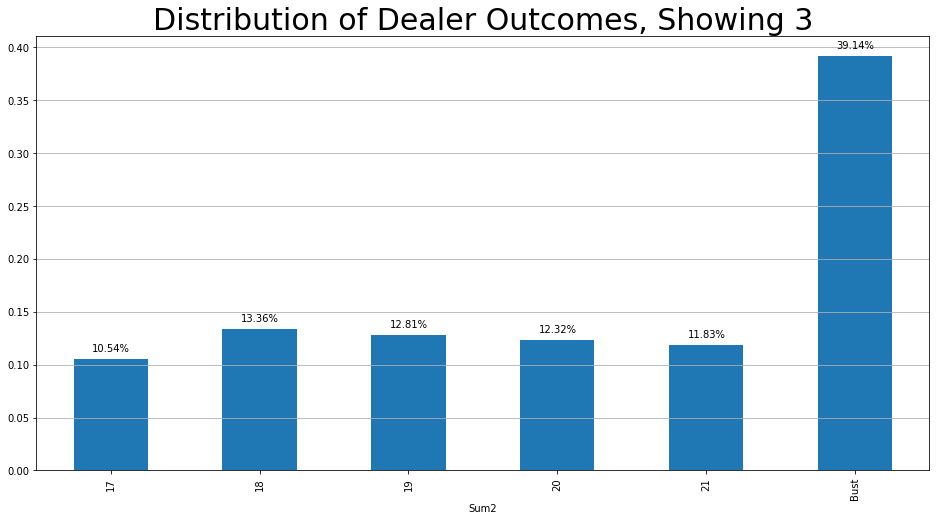

In [28]:
from matplotlib import pyplot as plt
dfg = df.groupby(by='Sum2')['Sum'].count()/len(df)
plt.figure(figsize=(16,8))
ax = dfg.plot.bar(x=dfg.index, y=dfg.values)
ax.grid(axis='y')
for i, x in enumerate(dfg.values):
    plt.text(i-0.125, x+0.0075, f'{np.round(x*100,2)}%')
plt.title(f'Distribution of Dealer Outcomes, Showing {show}', size=30)
plt.show()

### Let's look at the expected value for all scenarios where strategy suggests we stay (17 & above)

In [52]:
ev = pd.DataFrame(dfg).reset_index()
def coef(you, dealer):
    coef = -1
    if dealer == 'Bust' or you > int(dealer):
        coef = 1
    elif you == int(dealer):
        coef = 0
    return coef
for you in [17, 18, 19, 20, 21]:
    ev[f'Coef{you}'] = ev['Sum2'].apply(lambda x: coef(you, x))
    ev[f'ev{you}'] = ev['Sum'] * ev[f'Coef{you}']

In [53]:
ev

,Sum2,Sum,Coef17,ev17,Coef18,ev18,Coef19,ev19,Coef20,ev20,Coef21,ev21
0,17,0.105381,0,0.000000,1,0.105381,1,0.105381,1,0.105381,1,0.105381
1,18,0.133637,-1,-0.133637,0,0.000000,1,0.133637,1,0.133637,1,0.133637
2,19,0.128107,-1,-0.128107,-1,-0.128107,0,0.000000,1,0.128107,1,0.128107
3,20,0.123222,-1,-0.123222,-1,-0.123222,-1,-0.123222,0,0.000000,1,0.123222
4,21,0.118268,-1,-0.118268,-1,-0.118268,-1,-0.118268,-1,-0.118268,0,0.000000
5,Bust,0.391385,1,0.391385,1,0.391385,1,0.391385,1,0.391385,1,0.391385


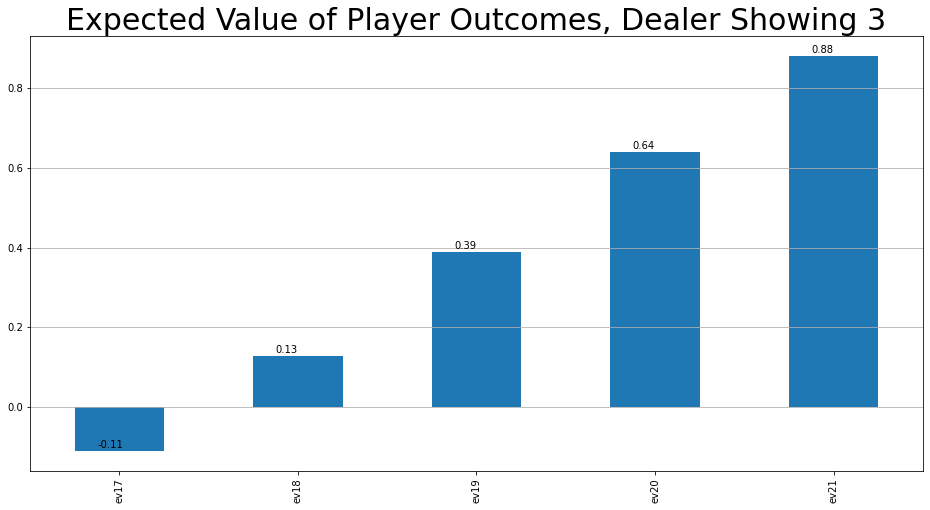

In [59]:
dfg = ev.sum()[[x for x in ev.columns if 'ev' in x]].copy()
plt.figure(figsize=(16,8))
ax = dfg.plot.bar(x=dfg.index, y=dfg.values)
ax.grid(axis='y')
for i, x in enumerate(dfg.values):
    plt.text(i-0.125, x+0.0075, f'{np.round(x,2)}')
plt.title(f'Expected Value of Player Outcomes, Dealer Showing {show}', size=30)
plt.show()

### Comparing EV of hitting versus stay when you have `17` | Dealer Shows = `3`
- Hit
  - If you hit you have a `76.9%` of busting; `EV=-1*0.769=-0.769=10/13`
  - If you don't bust (`23.1%`) you have an equal probability of landing a 19, 20, and 21
    - EV of 19, 20, and 21 are `0.39, 0.64, 0.88` respectively per the above
  - EV = `-0.62` = -1 * 0.769 + 0.39 * 0.077 + 0.064 + 0.077 + 0.88 * 0.077
- Stay
  - EV = `-0.11` per the above
  
Since `EV_Stay` > `EV_Hit` (-0.11 > -0.62), you should stay per the recommended strategy.

In [177]:
df.sample(n=50, random_state=4761)

,Sum,Bust,Blackjack,Cards,Original Cards
693945,26,True,False,"3, 5, 8, J",3 5 8 J
593379,17,False,False,"3, 6, 8",3 6 8
896531,20,False,False,"3, 4, 5, 8",3 8 5 4
11755,19,False,False,"3, 6, 10",3 6 10
39051,23,True,False,"3, 10, 10",3 10 10
302640,26,True,False,"2, 3, 9, J, A, A",3 A 2 A 9 J
814179,18,False,False,"3, 5, J",3 5 J
568673,21,False,False,"3, 8, Q",3 Q 8
430491,18,False,False,"2, 3, 3, K",3 3 K 2
153561,23,True,False,"3, K, K",3 K K


# Determine bust rate for all dealer showings

In [184]:
res = []
n = 1000000
for show in ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']:
    for _ in range(n):
        dealer = Dealer(show=show)
        while not dealer.stay:
            dealer.play()
        res.append([show, dealer.sum, dealer.bust, dealer.blackjack, ', '.join([x.sym for x in dealer.cards]), ', '.join([x.sym for x in dealer.rawCards])])
        del dealer
df3 = pd.DataFrame(res, columns=['Show', 'Sum', 'Bust', 'Blackjack', 'Cards', 'Original Cards'])

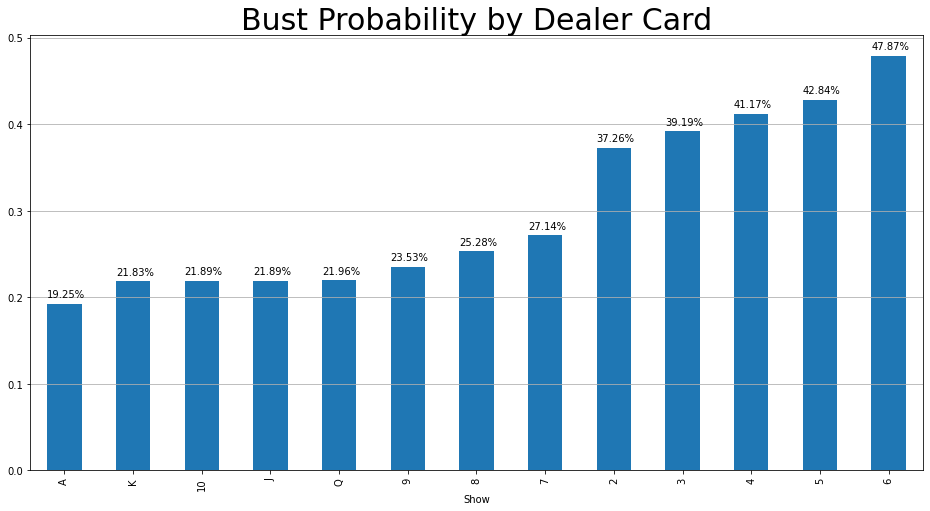

In [213]:
from matplotlib import pyplot as plt
#data = [[30, 25, 50, 20],[40, 23, 51, 17],[35, 22, 45, 19]]
dfg = df3.groupby(by='Show')['Bust'].sum()/df3.groupby(by='Show')['Bust'].count()
dfg.sort_values(inplace=True)
plt.figure(figsize=(16,8))
ax = dfg.plot.bar(x=dfg.index, y=dfg.values)
ax.grid(axis='y')
for i, x in enumerate(dfg.values):
    plt.text((i+i-0.5)/2, x+0.0075, f'{np.round(x*100,2)}%')
plt.title('Bust Probability by Dealer Card', size=30)
plt.show()

In [215]:
import sys; sys.getsizeof(df3)/2**30

2.3757627233862877

In [216]:
sys.getsizeof(res)/2**30

0.10810988396406174

In [217]:
del df3